## Эксперименты с моделями

### Импорт зависимостей

**Загрузка библиотек**

In [1]:
import pandas as pd
import numpy as np

In [2]:
import nltk
from nltk import pos_tag, ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from html import unescape

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [7]:
from sklearn.model_selection import cross_validate

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
from sklearn.model_selection import cross_val_score

In [13]:
from sklearn.metrics import roc_auc_score

In [14]:
import optuna, catboost

/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Определяем функции, которые нам понадобятся в экспериментах**

In [15]:
def prettify_scores(scores_dict, model_name):
    mean_scores = pd.DataFrame(scores_dict).iloc[:,2:].mean(axis=0)
    return pd.DataFrame(
        data=mean_scores.values.reshape(1, -1), 
        columns=['Precision', 'Recall', 'F1', 'ROC-AUC'], 
        index=[model_name]
    )

In [16]:
def return_best_param(cv_dict, param_name):
    cv_df = pd.DataFrame(cv_dict).loc[:, [f'param_{param_name}', 'mean_test_score', 'mean_train_score']]
    cv_df['roc_auc_diff'] = np.abs(cv_df.mean_train_score - cv_df.mean_test_score)
    return cv_df.query('roc_auc_diff < 0.11').sort_values('mean_test_score')[f'param_{param_name}'].iloc[-1]

In [17]:
def return_best_params(cv_dict, param1_name, param2_name):
    res_df = pd.DataFrame(
        cv_dict
    ).loc[:, [f'param_{"max_depth"}', f'param_{"min_samples_split"}', 'mean_train_score', 'mean_test_score']]
    res_df['roc_auc_diff'] = np.abs(res_df.mean_train_score - res_df.mean_test_score)
    return res_df.query(
        'roc_auc_diff < 0.11'
    ).sort_values(
        'mean_test_score'
    ).iloc[-1].loc[[f'param_{"max_depth"}', f'param_{"min_samples_split"}']].values.tolist()

**Зарузка данных**

In [18]:
df = pd.read_parquet(
    'elon_musk_tweets_labeled.parquet'
).drop(
    [
        'id', 
        'hashtags', 
        'user_name', 
        'user_created', 
        'is_retweet', 
        'date'
    ], 
    axis=1
)  # Файл формируется в ноутбуке preprocessing

**Предварительная обработка данных**

In [19]:
df = pd.get_dummies(
    df, 
    columns=['user_location', 'user_description', 'user_verified', 'source'], 
    drop_first=True, 
    dtype=int
)

Очистка:

In [20]:
df['text'] = df['text'].apply(unescape)

In [21]:
HTML_symbols_check = ['&quot;', '&amp;', '&lt', '&gt;', '&apos;', '&#39;'] #Проверяем, что HTML-cущности заменены на соответствующие символы

for symbol in HTML_symbols_check:
    if df['text'].str.contains(symbol).any():
        print(f"Символ '{symbol}' найден в датасете.")
    else:
        print(f"Символ '{symbol}' не найден в датасете.")

Символ '&quot;' не найден в датасете.
Символ '&amp;' не найден в датасете.
Символ '&lt' не найден в датасете.
Символ '&gt;' не найден в датасете.
Символ '&apos;' не найден в датасете.
Символ '&#39;' не найден в датасете.


In [22]:
df['text'] = df['text'].str.replace(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', regex=True) #Удаляем emails
df['text'] = df['text'].str.replace(r'@([A-Za-z0-9_]{1,})', '', regex=True) #Удаляем ники
df['text'] = df['text'].str.replace(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', '', regex=True) #Удаляем urls

df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace(r'[^a-zA-Z\s]', '', regex=True) #Удаляем знаки препинания и цифры и оставляем только буквы и пробелы
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()  #Удаляем лишние пробелы

Токенизация:

In [23]:
df['tokens'] = df['text'].apply(word_tokenize)

Удаление стоп-слов:

In [24]:
def delete_stopwords(tokens):
    cleaned = []
    for word in tokens:
        if word not in stop_words:
            cleaned.append(word)
    return cleaned

df['cleaned_tokens'] = df['tokens'].apply(delete_stopwords)

Лемматизация:

In [25]:
lemmatizer = WordNetLemmatizer()

In [26]:
def lemmatize_tokens(tokens):
    lemmatized = []
    for word in tokens:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

df['lemmatized'] = df['cleaned_tokens'].apply(lemmatize_tokens)

In [27]:
df['lemmatized'] = df['lemmatized'].apply(' '.join)

In [28]:
df.drop(['text', 'tokens', 'cleaned_tokens'], axis=1, inplace=True)

### Простые правила

**Формируем $X, y$**

In [29]:
X = df.lemmatized
y = df.feeling_auto
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**Рандом**

In [30]:
y_pred = np.random.randint(low=0, high=1, size=y_test.shape[0])
accuracy_score(y_test, y_pred)

0.38261851015801357

**Простые правила**

In [31]:
def rule_predict(x):
    return ~x.str.contains('(bad|sad)', regex=True)

In [32]:
y_pred = rule_predict(X_test)

/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_76585/819608852.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  return ~x.str.contains('(bad|sad)', regex=True)


In [33]:
accuracy_score(y_test, y_pred)

0.6224604966139955

**Словарный подход**

In [34]:
!file -I ./opinion-lexicon-English/negative-words.txt | sed 's/.*charset=//g'

iso-8859-1


In [35]:
with open('./opinion-lexicon-English/negative-words.txt', 'r', encoding='iso-8859-1') as f:
    neg = f.read()

In [36]:
with open('./opinion-lexicon-English/positive-words.txt', 'r', encoding='iso-8859-1') as f:
    pos = f.read()

In [37]:
pos = pos.split('\n')[31:]
neg = neg.split('\n')[31:]

In [38]:
sentiment_dict = {**{w: 1 for w in pos}, **{w: -1 for w in neg}}

In [39]:
def get_dict_scores(tweets):
    return np.array(list(map(lambda x : sentiment_dict.get(x, 0), tweets)))

In [40]:
def get_prediction(X, proba_func):
    return X.str.split().apply(lambda lst : proba_func(get_dict_scores(lst))).fillna(0.5)

Примеры трех подходов:

In [41]:
y_pred = get_prediction(X_test, lambda scores : np.mean(scores) > 0.5)  # simple mean

/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [42]:
y_pred = get_prediction(
    X_test, 
    lambda scores : ((scores.sum() - (1 - scores).sum()) / ((scores.sum() + (1 - scores).sum()))) > 0.5
)  # relative proportion

/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_76585/2307301785.py:3: RuntimeWarning: invalid value encountered in scalar divide
  lambda scores : ((scores.sum() - (1 - scores).sum()) / ((scores.sum() + (1 - scores).sum()))) > 0.5


In [43]:
y_pred = get_prediction(
    X_test, 
    lambda scores : np.log(np.sum(scores[scores == 1]) + 0.5) - np.log(np.sum(scores[scores == 0]) + 0.5) > 0.5
)  # logit

Наилучший из них:

In [45]:
accuracy_score(y_test, y_pred)

0.5744920993227991

### Простые модели, BoW

Логично сравнивать не как модели ведут себя на базовых параметрах, а какого максимума они способны достичь. Ищем гиперпараметры, при которых модель лучше всего оценивает вероятности. Чтобы исключить переобучение, будем смотреть только на параметры, где разница в средних `ROC-AUC` на трейне и тесте не больше 10%.

**Формируем $X, y$**

Для начала подберем оптимальное количество фичей для `BoW`. Для этого замерим метрику `ROC-AUC` для простейшей модели (Наивный Байес), обученной только на векторных представлениях, и посмотрим, после какого значения добавления новых фичей уже практически не улучшает оценку вероятностей этой моделью.

In [46]:
%%time

param_vals = list(range(1, 3000, 50))
metric_vals = []

for param_max_features in param_vals:
    vectorizer = CountVectorizer(max_features=param_max_features)
    tweets_bow = vectorizer.fit_transform(df['lemmatized'])
    
    tweets_bow = pd.DataFrame(
        data=tweets_bow.toarray(), 
        columns=vectorizer.get_feature_names_out()
    )
    
    X = tweets_bow
    y = df.feeling_auto

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    metric_vals.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

CPU times: user 35.9 s, sys: 23.3 s, total: 59.2 s
Wall time: 8.62 s


Видим, что график `ROC-AUC` стабилизируется примерно после `x=700` примерно на уровне `y=0.8` Поэтому выберем `max_features=700`.

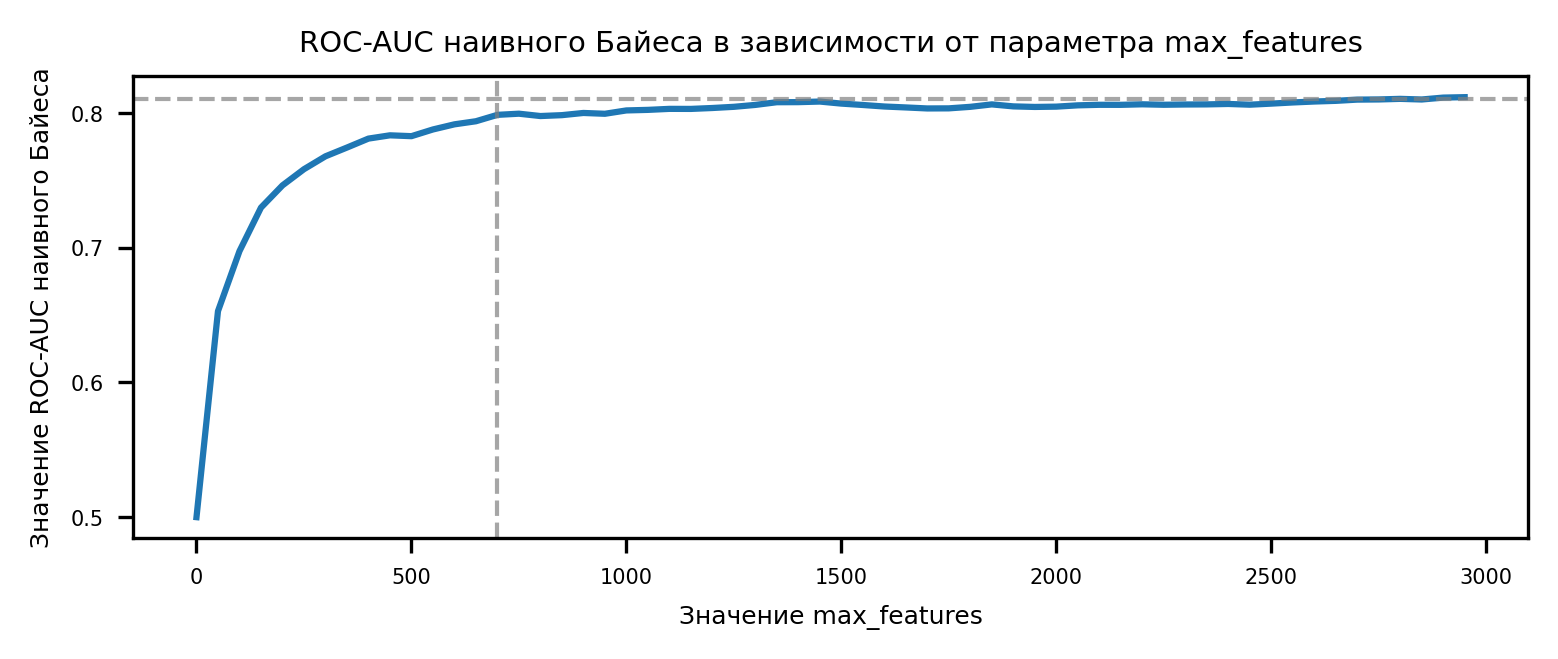

In [47]:
plt.figure(figsize=(6, 2), dpi=300)
plt.plot(param_vals, metric_vals)

plt.title('ROC-AUC наивного Байеса в зависимости от параметра max_features', fontsize=7)
plt.xlabel('Значение max_features', fontsize=6)
plt.ylabel('Значение ROC-AUC наивного Байеса', fontsize=6)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.axvline(x=700, linestyle='--', c='grey', alpha=0.7, linewidth=1)
plt.axhline(y=0.81, linestyle='--', c='grey', alpha=0.7, linewidth=1)

Теперь создадим итоговый `X`, который будет содержать оптимальные `BoW`-представления + остальные фичи из датасета.

In [48]:
vectorizer = CountVectorizer(max_features=700)
tweets_bow = vectorizer.fit_transform(df['lemmatized'])

tweets_bow = pd.DataFrame(
    data=tweets_bow.toarray(), 
    columns=vectorizer.get_feature_names_out()
)

X = pd.concat([df, tweets_bow], axis=1).drop(['feeling_auto', 'lemmatized'], axis=1)
y = df.feeling_auto

In [49]:
simple_metric_vals = []

**BoW + Наивный Байес**

[Описание](https://scikit-learn.org/1.5/modules/naive_bayes.html)

In [50]:
%%time

gnb = GaussianNB()

simple_metric_vals.append(
    prettify_scores(
        scores_dict=cross_validate(
            estimator=gnb,
            X=X,
            y=y,
            scoring=['precision', 'recall', 'f1', 'roc_auc'],
            cv=10
        ),
        model_name='Наивный Байес + BoW'
    )
)

CPU times: user 360 ms, sys: 129 ms, total: 489 ms
Wall time: 494 ms


**BoW + $k$ ближайших соседей**

In [51]:
knn = KNeighborsClassifier()

Найдем оптимальные гиперпараметры:

In [52]:
%%time

grid_search_res = GridSearchCV(
    estimator=knn,
    param_grid={'n_neighbors': range(500, 1500, 50)},
    scoring='roc_auc',
    cv=10,
    return_train_score=True
).fit(X, y)

CPU times: user 12min 16s, sys: 5min 31s, total: 17min 48s
Wall time: 3min 30s


Посмотрим на результат:

In [53]:
knn = KNeighborsClassifier(
    n_neighbors=return_best_param(
        grid_search_res.cv_results_, 
        'n_neighbors'
    )
)

In [54]:
%%time

simple_metric_vals.append(
    prettify_scores(
        scores_dict=cross_validate(
            estimator=knn,
            X=X,
            y=y,
            scoring=['precision', 'recall', 'f1', 'roc_auc'],
            cv=10
        ),
        model_name='kNN + BoW'
    )
)

CPU times: user 18.6 s, sys: 7.8 s, total: 26.4 s
Wall time: 3.85 s


**BoW + Логистическая регрессия**

In [55]:
lr = LogisticRegression(max_iter=1000)

In [56]:
%%time

grid_search_res = GridSearchCV(
    estimator=lr,
    param_grid={'C': np.linspace(0.1, 1, 50)},
    scoring='roc_auc',
    cv=10,
    return_train_score=True
).fit(X, y)

CPU times: user 25min 13s, sys: 1min 48s, total: 27min 1s
Wall time: 3min 51s


In [57]:
lr = LogisticRegression(
    max_iter=1000, 
    C=return_best_param(
        grid_search_res.cv_results_, 
        'C'
    )
)

In [58]:
%%time

simple_metric_vals.append(
    prettify_scores(
        scores_dict=cross_validate(
            estimator=lr,
            X=X,
            y=y,
            scoring=['precision', 'recall', 'f1', 'roc_auc'],
            cv=10
        ),
        model_name='Логистическая регрессия + BoW'
    )
)

CPU times: user 33.3 s, sys: 1.88 s, total: 35.1 s
Wall time: 5.1 s


**Сравнение**

In [59]:
pd.concat(simple_metric_vals)

,Precision,Recall,F1,ROC-AUC
Наивный Байес + BoW,0.620196,0.981096,0.759797,0.641602
kNN + BoW,0.618395,1.000000,0.764207,0.633953
Логистическая регрессия + BoW,0.622948,0.990414,0.764811,0.618135


### Модели на основе деревьев, BoW

**Случайный лес**

Последовательный подбор параметров от маленького к большему.

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
rf = RandomForestClassifier()

In [62]:
%%time

grid_search_res = GridSearchCV(
    estimator=rf,
    param_grid={
        'max_depth': range(2, 20, 4),
        'min_samples_split': range(2, 20, 4)
    },
    scoring='roc_auc',
    cv=10,
    return_train_score=True
).fit(X, y)

CPU times: user 1min 12s, sys: 3.41 s, total: 1min 15s
Wall time: 1min 15s


In [63]:
best_max_depth, best_min_samples_split = return_best_params(
    grid_search_res.cv_results_, 
    'max_depth', 
    'min_samples_split'
)

rf = RandomForestClassifier(
    max_depth=int(best_max_depth),
    min_samples_split=int(best_min_samples_split)
)

In [64]:
%%time

simple_metric_vals.append(
    prettify_scores(
        scores_dict=cross_validate(
            estimator=rf,
            X=X,
            y=y,
            scoring=['precision', 'recall', 'f1', 'roc_auc'],
            cv=10
        ),
        model_name='Случайный лес + BoW'
    )
)

CPU times: user 1.15 s, sys: 86.4 ms, total: 1.24 s
Wall time: 1.24 s


In [65]:
pd.concat(simple_metric_vals)

,Precision,Recall,F1,ROC-AUC
Наивный Байес + BoW,0.620196,0.981096,0.759797,0.641602
kNN + BoW,0.618395,1.000000,0.764207,0.633953
Логистическая регрессия + BoW,0.622948,0.990414,0.764811,0.618135
Случайный лес + BoW,0.618395,1.000000,0.764207,0.645734


**Бустинг, `catboost`**

Продолжим ту же идею для подбора гиперпараметров, но уже с помощью более сложных инструментов, подходящих для перебора большого числа параметров по крупной сeтке.

In [66]:
def pr_diff(clf):
    train_scores = []
    test_scores = []

    for i in range(4):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=0)
        clf.fit(X_train, y_train)
        
        train_score = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
        test_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

        train_scores.append(train_score)
        test_scores.append(test_score)
    
    return np.abs(np.max(train_scores) - np.min(test_scores))

In [67]:
def objective(trial):
    params = {
        'num_trees': trial.suggest_int('num_trees', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'verbose': False
    }

    model = catboost.CatBoostClassifier(**params)
    metrics = [np.mean(cross_val_score(model, X=pd.DataFrame(X), y=y, scoring='roc_auc', cv=10)), pr_diff(model)]

    return metrics

In [68]:
study = optuna.create_study(
    directions=['maximize', 'minimize'],
    sampler=optuna.samplers.TPESampler()
)

[I 2024-12-11 23:50:01,981] A new study created in memory with name: no-name-6d51f0bd-4cb8-46f4-be05-5dc94537fe02


In [38]:
!pip list | grep -e "catboost.*"

553.14s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


catboost           1.2.7


In [69]:
study.optimize(
    func=objective,
    n_trials=10,
    timeout=600,
    show_progress_bar=True,
    gc_after_trial=True
)

  0%|                                                    | 0/10 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x177e5b790> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x177dbf450> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. Th

[I 2024-12-11 23:50:06,918] Trial 0 finished with values: [0.6269898293130857, 0.20303117442540186] and parameters: {'num_trees': 77, 'max_depth': 8, 'min_data_in_leaf': 41}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x176d7b990> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x177dd6710> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 23:50:08,223] Trial 1 finished with values: [0.6578259658711553, 0.13088732896542288] and parameters: {'num_trees': 19, 'max_depth': 4, 'min_data_in_leaf': 65}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x177dd6b90> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x3081ff590> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 23:50:09,735] Trial 2 finished with values: [0.6896216039875452, 0.09734562522362766] and parameters: {'num_trees': 42, 'max_depth': 2, 'min_data_in_leaf': 59}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x177dbe490> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x176d75650> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 23:50:10,995] Trial 3 finished with values: [0.6704360673550023, 0.10205328778699241] and parameters: {'num_trees': 17, 'max_depth': 4, 'min_data_in_leaf': 75}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x3081d6310> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x308195910> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 23:50:18,621] Trial 4 finished with values: [0.5942534212790821, 0.21249467276220946] and parameters: {'num_trees': 47, 'max_depth': 10, 'min_data_in_leaf': 58}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x3082ccad0> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x177f3d910> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 23:50:19,670] Trial 5 finished with values: [0.583539201756383, 0.05172846527422581] and parameters: {'num_trees': 9, 'max_depth': 2, 'min_data_in_leaf': 30}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x176dd6790> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x3080bc910> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 23:50:20,851] Trial 6 finished with values: [0.6392918800630321, 0.07270493744524842] and parameters: {'num_trees': 19, 'max_depth': 2, 'min_data_in_leaf': 58}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x3081f2290> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x308187f90> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 23:50:22,169] Trial 7 finished with values: [0.671462112984128, 0.11122471655270083] and parameters: {'num_trees': 22, 'max_depth': 4, 'min_data_in_leaf': 51}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x30804ae10> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x308009210> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 23:50:24,100] Trial 8 finished with values: [0.6798007780450362, 0.14543555584333645] and parameters: {'num_trees': 52, 'max_depth': 4, 'min_data_in_leaf': 10}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x177d62850> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x176d7ed90> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 23:50:26,827] Trial 9 finished with values: [0.6585330556966924, 0.14061516386286055] and parameters: {'num_trees': 93, 'max_depth': 4, 'min_data_in_leaf': 53}.


In [70]:
best_params = study.trials_dataframe().sort_values(
    by=['values_0', 'values_1'], 
    ascending=[False, True]
).iloc[0,-4:-1]

In [71]:
clf = catboost.CatBoostClassifier(
    max_depth=best_params.params_max_depth,
    min_data_in_leaf=best_params.params_min_data_in_leaf,
    num_trees=best_params.params_num_trees
)

In [72]:
%%time

simple_metric_vals.append(
    prettify_scores(
        scores_dict=cross_validate(
            estimator=clf,
            X=X,
            y=y,
            scoring=['precision', 'recall', 'f1', 'roc_auc'],
            cv=10
        ),
        model_name='CatBoostClassifier + BoW'
    )
)

/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x177d5d750> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x3082de6d0> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

Learning rate set to 0.384711
0:	learn: 0.6669184	total: 1.2ms	remaining: 49.3ms
1:	learn: 0.6548291	total: 2.38ms	remaining: 47.7ms
2:	learn: 0.6438427	total: 3.49ms	remaining: 45.3ms
3:	learn: 0.6402167	total: 4.65ms	remaining: 44.2ms
4:	learn: 0.6361737	total: 5.83ms	remaining: 43.1ms
5:	learn: 0.6310979	total: 7ms	remaining: 42ms
6:	learn: 0.6257634	total: 8.15ms	remaining: 40.8ms
7:	learn: 0.6224182	total: 9.3ms	remaining: 39.5ms
8:	learn: 0.6201442	total: 10.5ms	remaining: 38.4ms
9:	learn: 0.6174144	total: 11.7ms	remaining: 37.3ms
10:	learn: 0.6149705	total: 12.8ms	remaining: 36ms
11:	learn: 0.6106298	total: 13.9ms	remaining: 34.8ms
12:	learn: 0.6081404	total: 15.1ms	remaining: 33.8ms
13:	learn: 0.6051387	total: 16.3ms	remaining: 32.6ms
14:	learn: 0.6034126	total: 17.4ms	remaining: 31.4ms
15:	learn: 0.6014766	total: 18.6ms	remaining: 30.2ms
16:	learn: 0.6001381	total: 19.7ms	remaining: 29ms
17:	learn: 0.5978377	total: 20.8ms	remaining: 27.8ms
18:	learn: 0.5950130	total: 21.9ms	re

/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x3082de6d0> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x3082de6d0> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

41:	learn: 0.5571113	total: 48.7ms	remaining: 0us
Learning rate set to 0.384711
0:	learn: 0.6686595	total: 1.29ms	remaining: 53.1ms
1:	learn: 0.6570139	total: 2.48ms	remaining: 49.5ms
2:	learn: 0.6471114	total: 3.67ms	remaining: 47.7ms
3:	learn: 0.6439383	total: 4.87ms	remaining: 46.3ms
4:	learn: 0.6385317	total: 6.04ms	remaining: 44.7ms
5:	learn: 0.6337743	total: 7.18ms	remaining: 43.1ms
6:	learn: 0.6310074	total: 8.29ms	remaining: 41.5ms
7:	learn: 0.6278644	total: 9.42ms	remaining: 40ms
8:	learn: 0.6246959	total: 10.7ms	remaining: 39.1ms
9:	learn: 0.6220135	total: 11.8ms	remaining: 37.7ms
10:	learn: 0.6197001	total: 13.1ms	remaining: 36.8ms
11:	learn: 0.6169908	total: 14.2ms	remaining: 35.5ms
12:	learn: 0.6147030	total: 15.4ms	remaining: 34.3ms
13:	learn: 0.6128334	total: 16.6ms	remaining: 33.1ms
14:	learn: 0.6106654	total: 17.8ms	remaining: 32ms
15:	learn: 0.6089142	total: 18.9ms	remaining: 30.7ms
16:	learn: 0.6070371	total: 20.1ms	remaining: 29.6ms
17:	learn: 0.6041194	total: 21.3m

/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x308242310> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x308242310> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

22:	learn: 0.5919699	total: 26.6ms	remaining: 22ms
23:	learn: 0.5904833	total: 27.8ms	remaining: 20.8ms
24:	learn: 0.5884661	total: 28.9ms	remaining: 19.7ms
25:	learn: 0.5868611	total: 30.1ms	remaining: 18.5ms
26:	learn: 0.5848973	total: 31.3ms	remaining: 17.4ms
27:	learn: 0.5834575	total: 32.5ms	remaining: 16.2ms
28:	learn: 0.5812840	total: 33.7ms	remaining: 15.1ms
29:	learn: 0.5794280	total: 34.8ms	remaining: 13.9ms
30:	learn: 0.5782118	total: 36ms	remaining: 12.8ms
31:	learn: 0.5768846	total: 37.2ms	remaining: 11.6ms
32:	learn: 0.5757524	total: 38.7ms	remaining: 10.6ms
33:	learn: 0.5747209	total: 40.2ms	remaining: 9.45ms
34:	learn: 0.5732458	total: 41.4ms	remaining: 8.27ms
35:	learn: 0.5716904	total: 42.5ms	remaining: 7.09ms
36:	learn: 0.5702562	total: 43.8ms	remaining: 5.91ms
37:	learn: 0.5692635	total: 45ms	remaining: 4.73ms
38:	learn: 0.5680925	total: 46.2ms	remaining: 3.56ms
39:	learn: 0.5667542	total: 47.8ms	remaining: 2.39ms
40:	learn: 0.5657504	total: 49.1ms	remaining: 1.2ms


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x3081ee210> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x3081ee210> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

0:	learn: 0.6680599	total: 1.34ms	remaining: 54.9ms
1:	learn: 0.6602915	total: 2.65ms	remaining: 53ms
2:	learn: 0.6517410	total: 3.87ms	remaining: 50.3ms
3:	learn: 0.6481208	total: 5.08ms	remaining: 48.3ms
4:	learn: 0.6437727	total: 6.33ms	remaining: 46.8ms
5:	learn: 0.6381855	total: 7.59ms	remaining: 45.5ms
6:	learn: 0.6334837	total: 9.47ms	remaining: 47.4ms
7:	learn: 0.6301557	total: 10.7ms	remaining: 45.3ms
8:	learn: 0.6283731	total: 11.8ms	remaining: 43.1ms
9:	learn: 0.6254432	total: 12.9ms	remaining: 41.2ms
10:	learn: 0.6225221	total: 14ms	remaining: 39.6ms
11:	learn: 0.6192842	total: 15.2ms	remaining: 38.1ms
12:	learn: 0.6172657	total: 16.4ms	remaining: 36.6ms
13:	learn: 0.6159002	total: 17.7ms	remaining: 35.5ms
14:	learn: 0.6131435	total: 19.3ms	remaining: 34.8ms
15:	learn: 0.6115925	total: 20.6ms	remaining: 33.5ms
16:	learn: 0.6086028	total: 21.9ms	remaining: 32.2ms
17:	learn: 0.6066348	total: 23ms	remaining: 30.6ms
18:	learn: 0.6043703	total: 24.1ms	remaining: 29.2ms
19:	learn

/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x176d7cad0> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x176d7cad0> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

Learning rate set to 0.384742
0:	learn: 0.6689577	total: 1.29ms	remaining: 53.1ms
1:	learn: 0.6606456	total: 2.43ms	remaining: 48.6ms
2:	learn: 0.6524297	total: 3.56ms	remaining: 46.2ms
3:	learn: 0.6473257	total: 4.82ms	remaining: 45.8ms
4:	learn: 0.6421736	total: 6.09ms	remaining: 45.1ms
5:	learn: 0.6384351	total: 7.33ms	remaining: 44ms
6:	learn: 0.6347408	total: 8.55ms	remaining: 42.8ms
7:	learn: 0.6315504	total: 9.71ms	remaining: 41.3ms
8:	learn: 0.6298853	total: 11ms	remaining: 40.3ms
9:	learn: 0.6278835	total: 12.2ms	remaining: 39.1ms
10:	learn: 0.6234566	total: 13.5ms	remaining: 38ms
11:	learn: 0.6215464	total: 14.6ms	remaining: 36.4ms
12:	learn: 0.6183895	total: 15.8ms	remaining: 35.3ms
13:	learn: 0.6169174	total: 16.9ms	remaining: 33.9ms
14:	learn: 0.6157183	total: 18.1ms	remaining: 32.6ms
15:	learn: 0.6129251	total: 19.3ms	remaining: 31.4ms
16:	learn: 0.6099367	total: 20.6ms	remaining: 30.2ms
17:	learn: 0.6083806	total: 21.6ms	remaining: 28.8ms
18:	learn: 0.6055739	total: 22.8

/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x3081fc510> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x3081fc510> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

Learning rate set to 0.384742
0:	learn: 0.6702528	total: 1.33ms	remaining: 54.6ms
1:	learn: 0.6619282	total: 2.6ms	remaining: 52ms
2:	learn: 0.6549590	total: 3.72ms	remaining: 48.3ms
3:	learn: 0.6486345	total: 5.02ms	remaining: 47.7ms
4:	learn: 0.6445346	total: 6.29ms	remaining: 46.5ms
5:	learn: 0.6396330	total: 7.4ms	remaining: 44.4ms
6:	learn: 0.6337494	total: 8.62ms	remaining: 43.1ms
7:	learn: 0.6311594	total: 9.67ms	remaining: 41.1ms
8:	learn: 0.6301055	total: 10.8ms	remaining: 39.6ms
9:	learn: 0.6270833	total: 11.9ms	remaining: 38.2ms
10:	learn: 0.6244256	total: 13.1ms	remaining: 36.9ms
11:	learn: 0.6220703	total: 14.1ms	remaining: 35.4ms
12:	learn: 0.6198343	total: 15.3ms	remaining: 34.1ms
13:	learn: 0.6182496	total: 16.4ms	remaining: 32.8ms
14:	learn: 0.6152997	total: 17.6ms	remaining: 31.6ms
15:	learn: 0.6116919	total: 18.7ms	remaining: 30.5ms
16:	learn: 0.6101248	total: 19.8ms	remaining: 29.2ms
17:	learn: 0.6082549	total: 20.9ms	remaining: 27.9ms
18:	learn: 0.6058684	total: 22

/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x177e16810> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x177e16810> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

In [74]:
pd.concat(simple_metric_vals)

,Precision,Recall,F1,ROC-AUC
Наивный Байес + BoW,0.620196,0.981096,0.759797,0.641602
kNN + BoW,0.618395,1.000000,0.764207,0.633953
Логистическая регрессия + BoW,0.622948,0.990414,0.764811,0.618135
Случайный лес + BoW,0.618395,1.000000,0.764207,0.645734
CatBoostClassifier + BoW,0.649051,0.887692,0.742791,0.689622


### Простые модели, tf-IDF

In [75]:
%%time

param_vals = list(range(1, 3000, 50))
metric_vals = []

for param_max_features in param_vals:
    vectorizer = TfidfVectorizer(max_features=param_max_features)
    tweets_bow = vectorizer.fit_transform(df['lemmatized'])
    
    tweets_bow = pd.DataFrame(
        data=tweets_bow.toarray(), 
        columns=vectorizer.get_feature_names_out()
    )
    
    X = tweets_bow
    y = df.feeling_auto

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    metric_vals.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

CPU times: user 22 s, sys: 12.1 s, total: 34.1 s
Wall time: 4.82 s


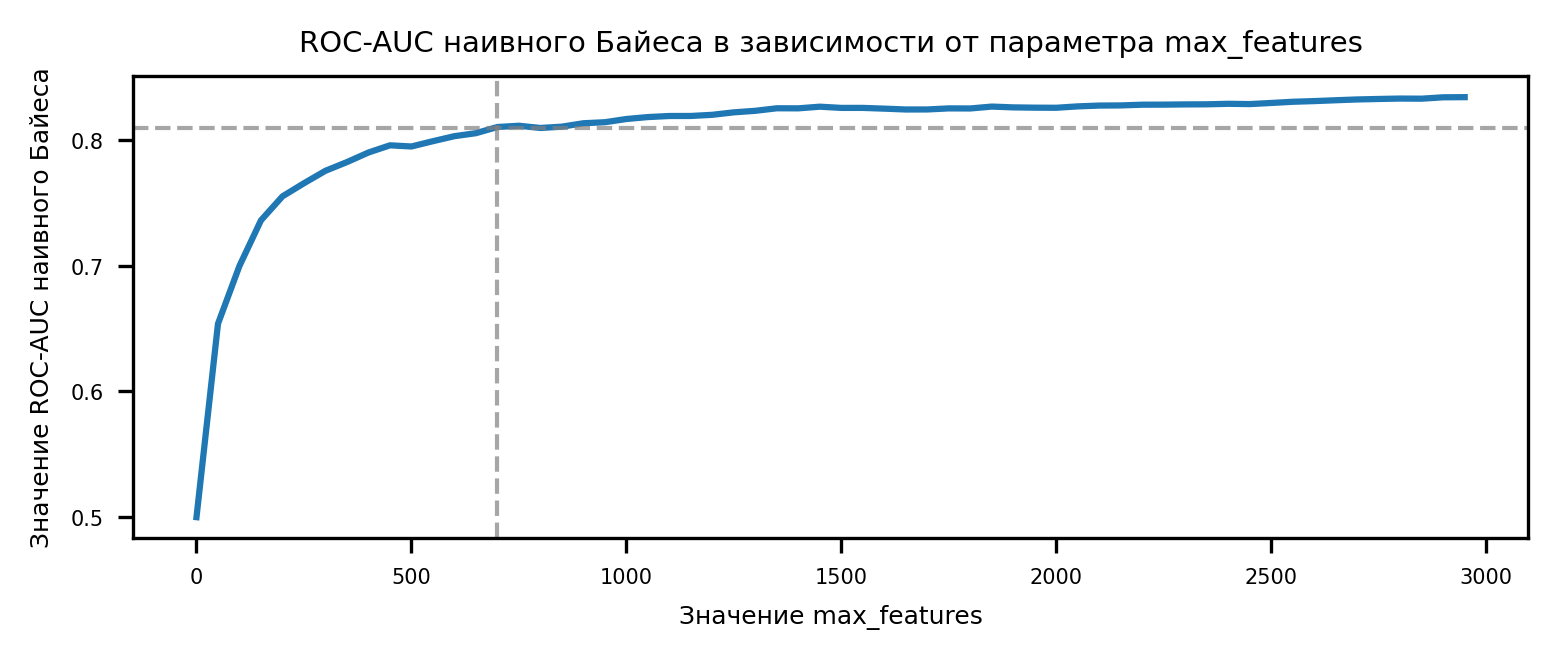

In [76]:
plt.figure(figsize=(6, 2), dpi=300)
plt.plot(param_vals, metric_vals)

plt.title('ROC-AUC наивного Байеса в зависимости от параметра max_features', fontsize=7)
plt.xlabel('Значение max_features', fontsize=6)
plt.ylabel('Значение ROC-AUC наивного Байеса', fontsize=6)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.axvline(x=700, linestyle='--', c='grey', alpha=0.7, linewidth=1)
plt.axhline(y=0.81, linestyle='--', c='grey', alpha=0.7, linewidth=1)

In [77]:
vectorizer = TfidfVectorizer(max_features=700)
tweets_bow = vectorizer.fit_transform(df['lemmatized'])

tweets_bow = pd.DataFrame(
    data=tweets_bow.toarray(), 
    columns=vectorizer.get_feature_names_out()
)

X = pd.concat([df, tweets_bow], axis=1).drop(['feeling_auto', 'lemmatized'], axis=1)
y = df.feeling_auto

In [78]:
simple_metric_vals = []

**tf-IDF + Наивный Байес**

In [79]:
%%time

gnb = GaussianNB()

simple_metric_vals.append(
    prettify_scores(
        scores_dict=cross_validate(
            estimator=gnb,
            X=X,
            y=y,
            scoring=['precision', 'recall', 'f1', 'roc_auc'],
            cv=10
        ),
        model_name='Наивный Байес + tf-IDF'
    )
)

CPU times: user 385 ms, sys: 114 ms, total: 499 ms
Wall time: 416 ms


**tf-IDF + $k$ ближайших соседей**

In [80]:
knn = KNeighborsClassifier()

In [81]:
%%time

grid_search_res = GridSearchCV(
    estimator=knn,
    param_grid={'n_neighbors': range(500, 1500, 50)},
    scoring='roc_auc',
    cv=10,
    return_train_score=True
).fit(X, y)

CPU times: user 16min 24s, sys: 3min 5s, total: 19min 29s
Wall time: 3min 19s


In [82]:
knn = KNeighborsClassifier(
    n_neighbors=return_best_param(
        grid_search_res.cv_results_, 
        'n_neighbors'
    )
)

In [83]:
%%time

simple_metric_vals.append(
    prettify_scores(
        scores_dict=cross_validate(
            estimator=knn,
            X=X,
            y=y,
            scoring=['precision', 'recall', 'f1', 'roc_auc'],
            cv=10
        ),
        model_name='tf-idf + tf-IDF'
    )
)

CPU times: user 12.4 s, sys: 3.19 s, total: 15.6 s
Wall time: 2.76 s


**TF-IDF + Логистическая регрессия**

In [84]:
lr = LogisticRegression(max_iter=1000)

In [ ]:
%%time

grid_search_res = GridSearchCV(
    estimator=lr,
    param_grid={'C': np.linspace(0.1, 1, 50)},
    scoring='roc_auc',
    cv=10,
    return_train_score=True
).fit(X, y)

In [ ]:
lr = LogisticRegression(
    max_iter=1000, 
    C=return_best_param(
        grid_search_res.cv_results_, 
        'C'
    )
)

In [ ]:
%%time

simple_metric_vals.append(
    prettify_scores(
        scores_dict=cross_validate(
            estimator=lr,
            X=X,
            y=y,
            scoring=['precision', 'recall', 'f1', 'roc_auc'],
            cv=10
        ),
        model_name='Логистическая регрессия + tf-IDF'
    )
)

In [ ]:
pd.concat(simple_metric_vals)

### Модели на основе деревьев, tf-IDF

**`RandomForestClassifier`**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()

In [ ]:
%%time

grid_search_res = GridSearchCV(
    estimator=rf,
    param_grid={
        'max_depth': range(2, 20, 4),
        'min_samples_split': range(2, 20, 4)
    },
    scoring='roc_auc',
    cv=10,
    return_train_score=True
).fit(X, y)

In [ ]:
best_max_depth, best_min_samples_split = return_best_params(
    grid_search_res.cv_results_, 
    'max_depth', 
    'min_samples_split'
)

rf = RandomForestClassifier(
    max_depth=int(best_max_depth),
    min_samples_split=int(best_min_samples_split)
)

In [ ]:
%%time

simple_metric_vals.append(
    prettify_scores(
        scores_dict=cross_validate(
            estimator=rf,
            X=X,
            y=y,
            scoring=['precision', 'recall', 'f1', 'roc_auc'],
            cv=10
        ),
        model_name='Случайный лес + tf-IDF'
    )
)

In [ ]:
pd.concat(simple_metric_vals)

**catboost**

In [ ]:
def pr_diff(clf):
    train_scores = []
    test_scores = []

    for i in range(4):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=0)
        clf.fit(X_train, y_train)
        
        train_score = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
        test_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

        train_scores.append(train_score)
        test_scores.append(test_score)
    
    return np.abs(np.max(train_scores) - np.min(test_scores))

In [ ]:
def objective(trial):
    params = {
        'num_trees': trial.suggest_int('num_trees', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'verbose': False
    }

    model = catboost.CatBoostClassifier(**params)
    metrics = [np.mean(cross_val_score(model, X=pd.DataFrame(X), y=y, scoring='roc_auc', cv=10)), pr_diff(model)]

    return metrics

In [ ]:
study = optuna.create_study(
    directions=['maximize', 'minimize'],
    sampler=optuna.samplers.TPESampler()
)

In [ ]:
!pip list | grep -e "catboost.*"

In [ ]:
study.optimize(
    func=objective,
    n_trials=10,
    timeout=600,
    show_progress_bar=True,
    gc_after_trial=True
)

In [ ]:
best_params = study.trials_dataframe().sort_values(
    by=['values_0', 'values_1'], 
    ascending=[False, True]
).iloc[0,-4:-1]

In [ ]:
clf = catboost.CatBoostClassifier(
    max_depth=best_params.params_max_depth,
    min_data_in_leaf=best_params.params_min_data_in_leaf,
    num_trees=best_params.params_num_trees
)

In [ ]:
%%time

simple_metric_vals.append(
    prettify_scores(
        scores_dict=cross_validate(
            estimator=clf,
            X=X,
            y=y,
            scoring=['precision', 'recall', 'f1', 'roc_auc'],
            cv=10
        ),
        model_name='CatBoostClassifier + tf-IDF'
    )
)

**Сравнение**

In [ ]:
pd.concat(simple_metric_vals)